In [217]:
import cmocean.cm as cm
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
# import statfieldodels.api as sm
import xarray as xr
import pickle
import os
from salishsea_tools import viz_tools, geo_tools
import netCDF4 as nc
import arrow
import copy
import math
import matplotlib.dates as mdates
from pathlib import Path
import gsw

Paths to collection of obs datasets and load them, and to a specific dataset:

In [218]:
obs_dir = Path("/ocean/atall/MOAD/Obs/PugetSound/ERDDAP/")
obs_file_TW = obs_dir / "L2_gridded_025_TW_20070101-20071231.nc"
ds_obs_TW = xr.open_dataset(obs_file_TW)
obs_file_HS = obs_dir / "L2_gridded_025_HS_20070101-20071231.nc"
ds_obs_HS = xr.open_dataset(obs_file_HS)
obs_file_NB = obs_dir / "L2_gridded_025_NB_20070101-20071231.nc"
ds_obs_NB = xr.open_dataset(obs_file_NB)

obs_dir2 = open("/data/rbeutel/obs/ctd/2007.p","rb") # Pickle file

Obs variables

In [220]:
# Twanoh
lon_obs_TW = ds_obs_TW.attrs["buoy_longitude"]
lon_obs_TW = float(lon_obs_TW.split(" ", maxsplit=1)[0])
lat_obs_TW = ds_obs_TW.attrs["buoy_latitude"]
lat_obs_TW = float(lat_obs_TW.split(" ", maxsplit=1)[0])
depth_obs_TW = ds_obs_TW.depth.sel()
time_obs_TW = ds_obs_TW.cast_start_time.sel()
oxy_obs_TW = ds_obs_TW.mass_concentration_of_oxygen_in_sea_water.sel() * 44.64
chl_obs_TW = ds_obs_TW.mass_concentration_of_chlorophyll_a_in_sea_water.sel()
no3_obs_TW = ds_obs_TW.mole_concentration_of_nitrate_in_sea_water.sel()
salt_obs_TW = gsw.SR_from_SP(ds_obs_TW.sea_water_practical_salinity.sel()) # from practical to ref salinity (g/kg)
temp_obs_TW = gsw.CT_from_t(salt_obs_TW, ds_obs_TW.sea_water_temperature.sel(), ds_obs_TW.sea_water_pressure.sel()) # from in-situ temp to cons temp
# Hoodsport
lon_obs_HS = ds_obs_HS.attrs["buoy_longitude"]
lon_obs_HS = float(lon_obs_HS.split(" ", maxsplit=1)[0])-1
lat_obs_HS = ds_obs_HS.attrs["buoy_latitude"]
lat_obs_HS = float(lat_obs_HS.split(" ", maxsplit=1)[0])
depth_obs_HS = ds_obs_HS.depth.sel()
time_obs_HS = ds_obs_HS.cast_start_time.sel()
oxy_obs_HS = ds_obs_HS.mass_concentration_of_oxygen_in_sea_water.sel() * 44.64
chl_obs_HS = ds_obs_HS.mass_concentration_of_chlorophyll_a_in_sea_water.sel()
no3_obs_HS = ds_obs_HS.mole_concentration_of_nitrate_in_sea_water.sel()
salt_obs_HS = gsw.SR_from_SP(ds_obs_HS.sea_water_practical_salinity.sel()) # from practical to ref salinity (g/kg)
temp_obs_HS = gsw.CT_from_t(salt_obs_HS, ds_obs_HS.sea_water_temperature.sel(), ds_obs_HS.sea_water_pressure.sel()) # from in-situ temp to cons temp
# NorthBuoy
lon_obs_NB = ds_obs_NB.attrs["buoy_longitude"]
lon_obs_NB = float(lon_obs_NB.split(" ", maxsplit=1)[0])
lat_obs_NB = ds_obs_NB.attrs["buoy_latitude"]
lat_obs_NB = float(lat_obs_NB.split(" ", maxsplit=1)[0])
depth_obs_NB = ds_obs_NB.depth.sel()
time_obs_NB = ds_obs_NB.cast_start_time.sel()
oxy_obs_NB = ds_obs_NB.mass_concentration_of_oxygen_in_sea_water.sel() * 44.64
chl_obs_NB = ds_obs_NB.mass_concentration_of_chlorophyll_a_in_sea_water.sel()
no3_obs_NB = ds_obs_NB.mole_concentration_of_nitrate_in_sea_water.sel()
salt_obs_NB = gsw.SR_from_SP(ds_obs_NB.sea_water_practical_salinity.sel()) # from practical to ref salinity (g/kg)
temp_obs_NB = gsw.CT_from_t(salt_obs_NB, ds_obs_NB.sea_water_temperature.sel(), ds_obs_NB.sea_water_pressure.sel()) # from in-situ temp to cons temp

Buoys position :  https://nwem.apl.washington.edu/prod_PugetSound.shtml

In [221]:
mycmap = copy.copy(cm.oxy)
mycmap.set_bad('darkgreen')

In [222]:
with xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc') as mesh:
    tmask = mesh.tmask
    mbathy = mesh.mbathy

In [223]:
# Constant and data rang
syear = 2007
eyear = 2007
smonth = 1
emonth = 12
startdate = arrow.get(syear, smonth, 1)
enddate = arrow.get(eyear, emonth, 31)
print (startdate, enddate)

2007-01-01T00:00:00+00:00 2007-12-31T00:00:00+00:00


In [224]:
with xr.open_dataset('/results2/SalishSea/nowcast-green.202111/01apr23/SalishSea_1d_20230401_20230401_chem_T.nc') as data_chem:
    oxy = data_chem['dissolved_oxygen']
with xr.open_dataset('/results2/SalishSea/nowcast-green.202111/01apr23/SalishSea_1d_20230401_20230401_biol_T.nc') as data_biol:
    no3 = data_biol['nitrate']
    don = data_biol['dissolved_organic_nitrogen']
    pon = data_biol['particulate_organic_nitrogen']
    dia = data_biol['diatoms']
    fla = data_biol['flagellates']
with xr.open_dataset('/results2/SalishSea/nowcast-green.202111/01apr23/SalishSea_1d_20230401_20230401_grid_T.nc') as data_grid:
    temp = data_grid['votemper']
    salt = data_grid['vosaline']
#    dens = data_grid['sigma_theta'] # almost same as salinity

In [225]:
tmask2_oxy = tmask.assign_coords(z=("z", oxy.deptht.data))
tmask2_oxy = tmask2_oxy.rename({"z": "deptht"})
tmask2_no3 = tmask.assign_coords(z=("z", no3.deptht.data))
tmask2_no3 = tmask2_no3.rename({"z": "deptht"})
tmask2_dia = tmask.assign_coords(z=("z", dia.deptht.data))
tmask2_dia = tmask2_dia.rename({"z": "deptht"})
tmask2_fla = tmask.assign_coords(z=("z", fla.deptht.data))
tmask2_fla = tmask2_fla.rename({"z": "deptht"})
tmask2_temp = tmask.assign_coords(z=("z", temp.deptht.data))
tmask2_temp = tmask2_temp.rename({"z": "deptht"})
tmask2_salt = tmask.assign_coords(z=("z", salt.deptht.data))
tmask2_salt = tmask2_salt.rename({"z": "deptht"})


In [226]:
print (oxy.deptht)

<xarray.DataArray 'deptht' (deptht: 40)>
array([  0.5     ,   1.500003,   2.500011,   3.500031,   4.500071,   5.500151,
         6.50031 ,   7.500623,   8.501236,   9.502433,  10.504766,  11.509312,
        12.518167,  13.535412,  14.568982,  15.634288,  16.761173,  18.007135,
        19.481785,  21.389978,  24.100256,  28.229916,  34.685757,  44.517723,
        58.484333,  76.58559 ,  98.06296 , 121.866516, 147.08946 , 173.11449 ,
       199.57304 , 226.2603  , 253.06664 , 279.93454 , 306.8342  , 333.75018 ,
       360.67453 , 387.6032  , 414.5341  , 441.4661  ], dtype=float32)
Coordinates:
  * deptht   (deptht) float32 0.5 1.5 2.5 3.5 4.5 ... 360.7 387.6 414.5 441.5
Attributes:
    standard_name:  sea_floor_depth
    long_name:      Sea Floor Depth
    units:          metres
    positive:       down


Extract the j, i obs from SalishSeaCast model (fall on an earth point)

In [227]:
grid_dir = Path("/ocean/atall/MOAD/grid/")
grid_map = Path("grid_from_lat_lon_mask999.nc")
grid_lons_lats = xr.open_dataset(grid_dir / grid_map)
grid_lons_lats

<xarray.Dataset>
Dimensions:  (lons: 9605, lats: 13585)
Coordinates:
  * lons     (lons) float64 -126.4 -126.4 -126.4 -126.4 ... -121.3 -121.3 -121.3
  * lats     (lats) float64 46.86 46.86 46.86 46.86 ... 51.1 51.1 51.1 51.1
Data variables:
    jj       (lats, lons) int16 ...
    ii       (lats, lons) int16 ...
Attributes:
    acknowledgements:      Based on find_closest point
    creator_email:         sallen@eoas.ubc.ca
    creator_name:          Salish Sea MEOPAR Project Contributors
    creator_url:           https://salishsea-meopar-docs.readthedocs.org/
    institution:           UBC EOAS
    institution_fullname:  Earth, Ocean & Atmospheric Sciences, University of...
    title:                 Grid position from lat/lons
    history:               [2021-02-25] File creation.
    Mask:                  from geometry and then corrected based on results,...

In [228]:
jtw_da = grid_lons_lats.jj.sel(lats=lat_obs_TW, lons=lon_obs_TW, method='nearest')
jtw = jtw_da.item()
itw_da = grid_lons_lats.ii.sel(lats=lat_obs_TW, lons=lon_obs_TW, method='nearest')
itw = itw_da.item()
jhs_da = grid_lons_lats.jj.sel(lats=lat_obs_HS, lons=lon_obs_HS, method='nearest')
jhs = jhs_da.item()
ihs_da = grid_lons_lats.ii.sel(lats=lat_obs_HS, lons=lon_obs_HS, method='nearest')
ihs = ihs_da.item()
jnb_da = grid_lons_lats.jj.sel(lats=lat_obs_NB, lons=lon_obs_NB, method='nearest')
jnb = jnb_da.item()
inb_da = grid_lons_lats.ii.sel(lats=lat_obs_NB, lons=lon_obs_NB, method='nearest')
inb = inb_da.item()
print((jtw,itw),(jhs,ihs),(jnb,inb))

(72, 123) (89, 114) (148, 243)


Buoy position in 202111 (4x4 pixels around)

In [229]:
#i1, i2, j1, j2 = (95, 200, 68, 160)  # Hood Canal all
#i1pw, i2pw, j1pw, j2pw = (257, 260, 102, 105)  # Point Wells 47.761N, -122.3972W 100 meters depth
#i1ci, i2ci, j1ci, j2ci = (151, 154, 29,32)  # Carr Inlet - 47.28N, -122.728W 47 meters depth
#i1db, i2db, j1db, j2db = (204, 207, 140, 143)  # Dabob bay 47.8034N, -122.8029W 100 meters depth
#i1nb, i2nb, j1nb, j2nb = (241, 244, 147, 150)  # Northbuoy (Hansville)
#i1hs, i2hs, j1hs, j2hs = (107, 110, 83, 86)           # Hoodsport buoy point in Lynch Cove (Hood Canal) - 47.4218N, -123.1126W 120 meters depth
#i1lc, i2lc, j1lc, j2lc = (122, 125, 70, 73)  # Twanoh buoy point in Lynch Cove (Hood Canal) - 47.375N, -123.0083W 35 meters depth

In [230]:
first = True
for ii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
    year = day.year
    yr2 = day.strftime("%y")
    month = day.month
    Month = day.strftime("%b").lower()
    day = day.day
    # set up filename to follow NEMO conventions
    filename_chem = f'/results2/SalishSea/nowcast-green.202111/{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_chem_T.nc'
    with xr.open_dataset(filename_chem) as ds_chem:
        oxyhs = ds_chem['dissolved_oxygen'][0, :, jhs, ihs].where(tmask2_oxy[0, :, jhs, ihs] == 1)
        oxytw = ds_chem['dissolved_oxygen'][0, :, jtw, itw].where(tmask2_oxy[0, :, jtw, itw] == 1)
        oxynb = ds_chem['dissolved_oxygen'][0, :, jnb, inb].where(tmask2_oxy[0, :, jnb, inb] == 1)
        if first:
            first = False
            oxyhs_ts = oxyhs
            oxytw_ts = oxytw
            oxynb_ts = oxynb
        else:
            oxyhs_ts = xr.concat([oxyhs_ts, oxyhs], dim='time_counter')
            oxytw_ts = xr.concat([oxytw_ts, oxytw], dim='time_counter')
            oxynb_ts = xr.concat([oxynb_ts, oxynb], dim='time_counter')

In [231]:
first = True
for ii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
    year = day.year
    yr2 = day.strftime("%y")
    month = day.month
    Month = day.strftime("%b").lower()
    day = day.day
    # set up filename to follow NEMO conventions
    filename_biol = f'/results2/SalishSea/nowcast-green.202111/{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_biol_T.nc'
    with xr.open_dataset(filename_biol) as ds_biol:
        no3hs = ds_biol['nitrate'][0, :, jhs, ihs].where(tmask2_no3[0, :, jhs, ihs] == 1)
        no3tw = ds_biol['nitrate'][0, :, jtw, itw].where(tmask2_no3[0, :, jtw, itw] == 1)
        no3nb = ds_biol['nitrate'][0, :, jnb, inb].where(tmask2_no3[0, :, jnb, inb] == 1)
        
        diatw = ds_biol['diatoms'][0, :, jtw, itw].where(tmask2_dia[0, :, jtw, itw] == 1)
        diahs = ds_biol['diatoms'][0, :, jhs, ihs].where(tmask2_dia[0, :, jhs, ihs] == 1)
        dianb = ds_biol['diatoms'][0, :, jnb, inb].where(tmask2_dia[0, :, jnb, inb] == 1)
        
        flatw = ds_biol['flagellates'][0, :, jtw, itw].where(tmask2_fla[0, :, jtw, itw] == 1)
        flahs = ds_biol['flagellates'][0, :, jhs, ihs].where(tmask2_fla[0, :, jhs, ihs] == 1)
        flanb = ds_biol['flagellates'][0, :, jnb, inb].where(tmask2_fla[0, :, jnb, inb] == 1)
        
        if first:
            first = False
            no3hs_ts = no3hs
            no3tw_ts = no3tw
            no3nb_ts = no3nb
         
            diatw_ts = diatw
            diahs_ts = diahs
            dianb_ts = dianb
         
            flatw_ts = flatw
            flahs_ts = flahs
            flanb_ts = flanb
        else:
            no3hs_ts = xr.concat([no3hs_ts, no3hs], dim='time_counter')
            no3tw_ts = xr.concat([no3tw_ts, no3tw], dim='time_counter')
            no3nb_ts = xr.concat([no3nb_ts, no3nb], dim='time_counter')
        
            diatw_ts = xr.concat([diatw_ts, diatw], dim='time_counter')
            diahs_ts = xr.concat([diahs_ts, diahs], dim='time_counter')
            dianb_ts = xr.concat([dianb_ts, dianb], dim='time_counter')
         
            flatw_ts = xr.concat([flatw_ts, flatw], dim='time_counter')
            diahs_ts = xr.concat([diahs_ts, diahs], dim='time_counter')
            flanb_ts = xr.concat([flanb_ts, flanb], dim='time_counter')
         

In [248]:
chltw_ts = (diatw_ts + flatw_ts)*2
chlhs_ts = (diahs_ts + flahs_ts)*2
chlnb_ts = (dianb_ts + flanb_ts)*2
chlhs_ts.shape

(729, 40)

In [233]:
first = True
for ii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
    year = day.year
    yr2 = day.strftime("%y")
    month = day.month
    Month = day.strftime("%b").lower()
    day = day.day
    # set up filename to follow NEMO conventions
    filename_grid = f'/results2/SalishSea/nowcast-green.202111/{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_grid_T.nc'
    with xr.open_dataset(filename_grid) as ds_grid:
        temphs = ds_grid['votemper'][0, :, jhs, ihs].where(tmask2_temp[0, :, jhs, ihs] == 1)
        temptw = ds_grid['votemper'][0, :, jtw, itw].where(tmask2_temp[0, :, jtw, itw] == 1)
        tempnb = ds_grid['votemper'][0, :, jnb, inb].where(tmask2_temp[0, :, jnb, inb] == 1)
        
        salths = ds_grid['vosaline'][0, :, jhs, ihs].where(tmask2_salt[0, :, jhs, ihs] == 1)
        salttw = ds_grid['vosaline'][0, :, jtw, itw].where(tmask2_salt[0, :, jtw, itw] == 1)
        saltnb = ds_grid['vosaline'][0, :, jnb, inb].where(tmask2_salt[0, :, jnb, inb] == 1)
          
        if first:
            first = False
            temphs_ts = temphs
            temptw_ts = temptw
            tempnb_ts = tempnb
        
            salths_ts = salths
            salttw_ts = salttw
            saltnb_ts = saltnb
        else:
            temphs_ts = xr.concat([temphs_ts, temphs], dim='time_counter')
            temptw_ts = xr.concat([temptw_ts, temptw], dim='time_counter')
            tempnb_ts = xr.concat([tempnb_ts, tempnb], dim='time_counter')
            
            salths_ts = xr.concat([salths_ts, salths], dim='time_counter')
            salttw_ts = xr.concat([salttw_ts, salttw], dim='time_counter')
            saltnb_ts = xr.concat([saltnb_ts, saltnb], dim='time_counter')
           

Twanoh in Lynch Cove - Hood Canal

Twanoh in Lynch Cove - Hood Canal 2007-01-01T00:00:00+00:00 2007-12-31T00:00:00+00:00


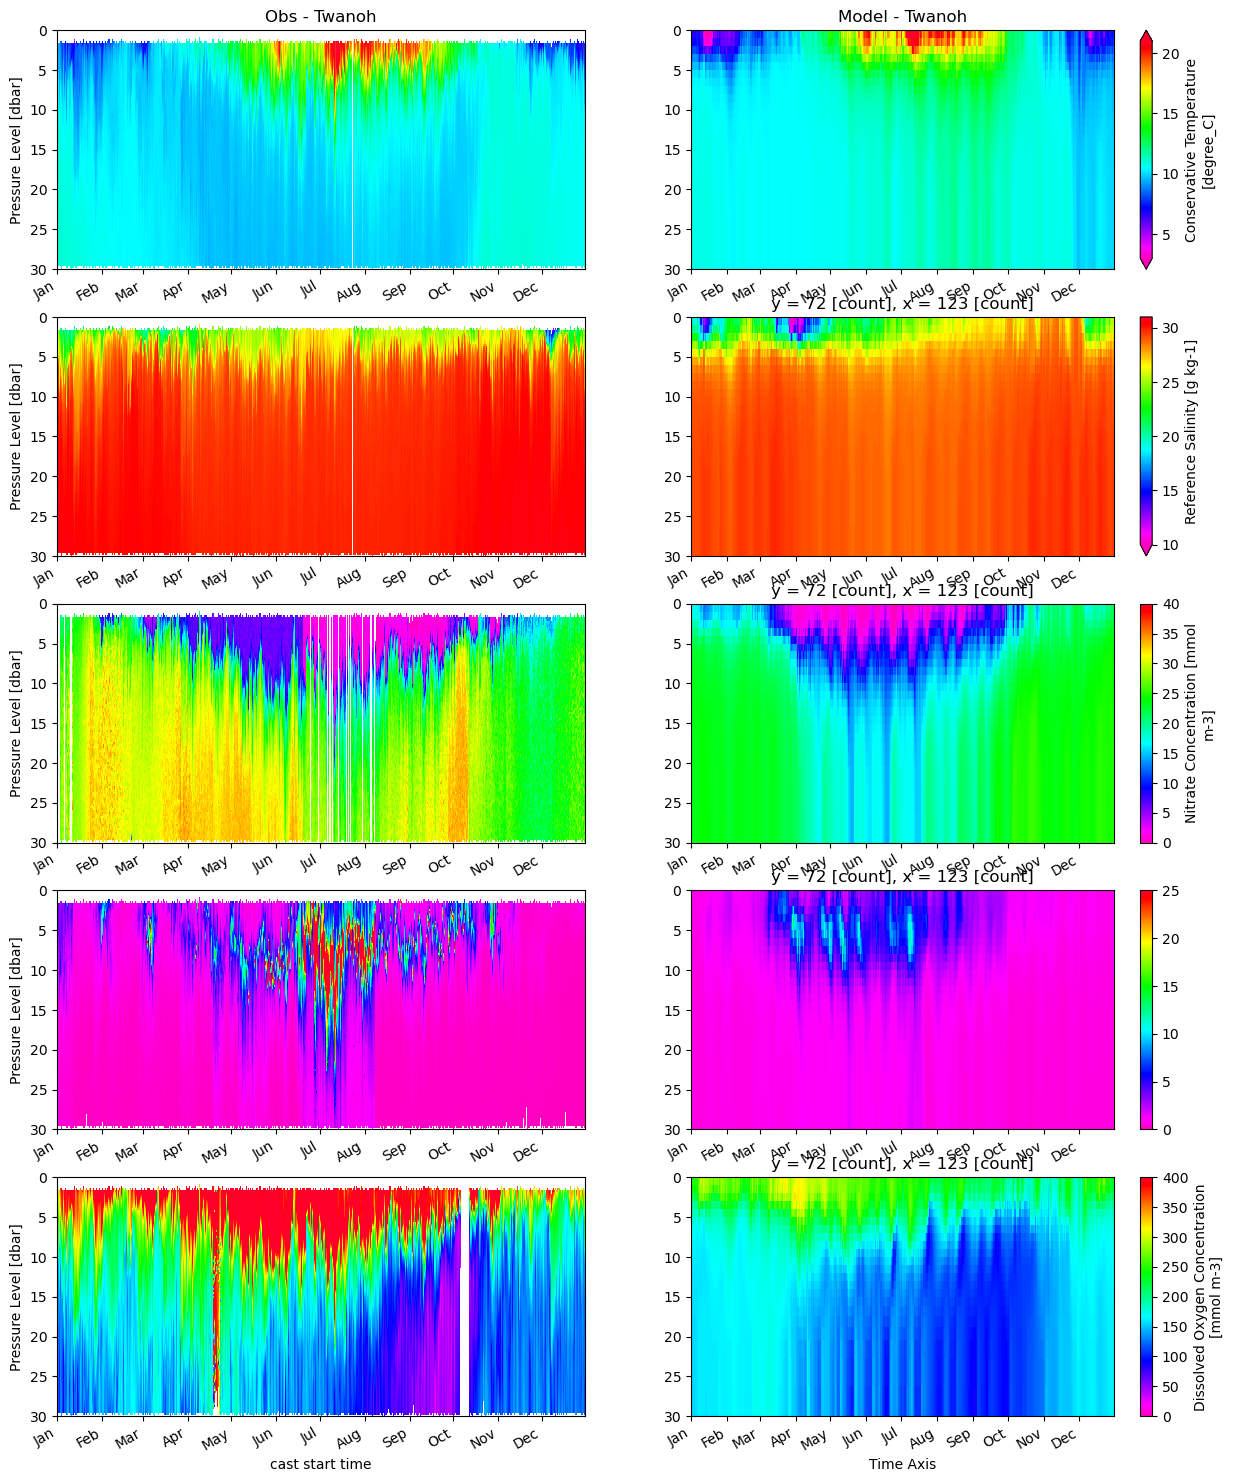

In [234]:
fig, ax = plt.subplots(5, 2, figsize=(15, 18))
temp_obs_TW.plot(ax=ax[0, 0], y="sea_water_pressure", yincrease=False, cmap='gist_rainbow_r', add_colorbar=False, vmin=3, vmax=21, ylim=(30, 0), xlim=(startdate, enddate));
salt_obs_TW.plot(ax=ax[1, 0], y="sea_water_pressure", yincrease=False, cmap= 'gist_rainbow_r', add_colorbar=False, vmin=10, vmax=31, ylim=(30, 0), xlim=(startdate, enddate));
no3_obs_TW.plot(ax=ax[2, 0], y="sea_water_pressure", yincrease=False, cmap='gist_rainbow_r', add_colorbar=False, vmin=0, vmax=40, ylim=(30, 0), xlim=(startdate, enddate));
chl_obs_TW.plot(ax=ax[3, 0], y="sea_water_pressure", yincrease=False, cmap='gist_rainbow_r', add_colorbar=False, vmin=0, vmax=25, ylim=(30, 0), xlim=(startdate, enddate));
oxy_obs_TW.plot(ax=ax[4, 0], y="sea_water_pressure", yincrease=False, cmap='gist_rainbow_r', add_colorbar=False, vmin=0, vmax=400, ylim=(30, 0), xlim=(startdate, enddate));

templc_ts[:, :24].plot(ax=ax[0, 1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=3, vmax=21, ylim=(30, 0), xlim=(startdate, enddate));
saltlc_ts[:, :24].plot(ax=ax[1, 1], y="deptht", yincrease=False, cmap= 'gist_rainbow_r', vmin=10, vmax=31, ylim=(30, 0), xlim=(startdate, enddate));
no3lc_ts[:, :24].plot(ax=ax[2, 1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=40, ylim=(30, 0), xlim=(startdate, enddate));
chllc_ts[:, :24].plot(ax=ax[3, 1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=25, ylim=(30, 0), xlim=(startdate, enddate));
oxytw_ts[:, :24].plot(ax=ax[4, 1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=400, ylim=(30, 0), xlim=(startdate, enddate));

ax[0, 1].set_ylabel('')
ax[1, 1].set_ylabel('')
ax[2, 1].set_ylabel('')
ax[3, 1].set_ylabel('')
ax[4, 1].set_ylabel('')
ax[0, 0].set_xlabel('')
ax[1, 0].set_xlabel('')
ax[2, 0].set_xlabel('')
ax[3, 0].set_xlabel('')
ax[0, 1].set_xlabel('')
ax[1, 1].set_xlabel('')
ax[2, 1].set_xlabel('')
ax[3, 1].set_xlabel('')

ax[0, 0].set_title('Obs - Twanoh')
ax[0, 1].set_title('Model - Twanoh')

# Make ticks on occurrences of each month:
ax[0, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[1, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[2, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[3, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[4, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0, 1].xaxis.set_major_locator(mdates.MonthLocator())
ax[1, 1].xaxis.set_major_locator(mdates.MonthLocator())
ax[2, 1].xaxis.set_major_locator(mdates.MonthLocator())
ax[3, 1].xaxis.set_major_locator(mdates.MonthLocator())
ax[4, 1].xaxis.set_major_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
ax[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[2, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[3, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[4, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[1, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[2, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[3, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[4, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

print('Twanoh in Lynch Cove - Hood Canal', startdate, enddate)

Hoodsport - central Hood Canal

Hoodsport in central Hood Canal 2007-01-01T00:00:00+00:00 2007-12-31T00:00:00+00:00


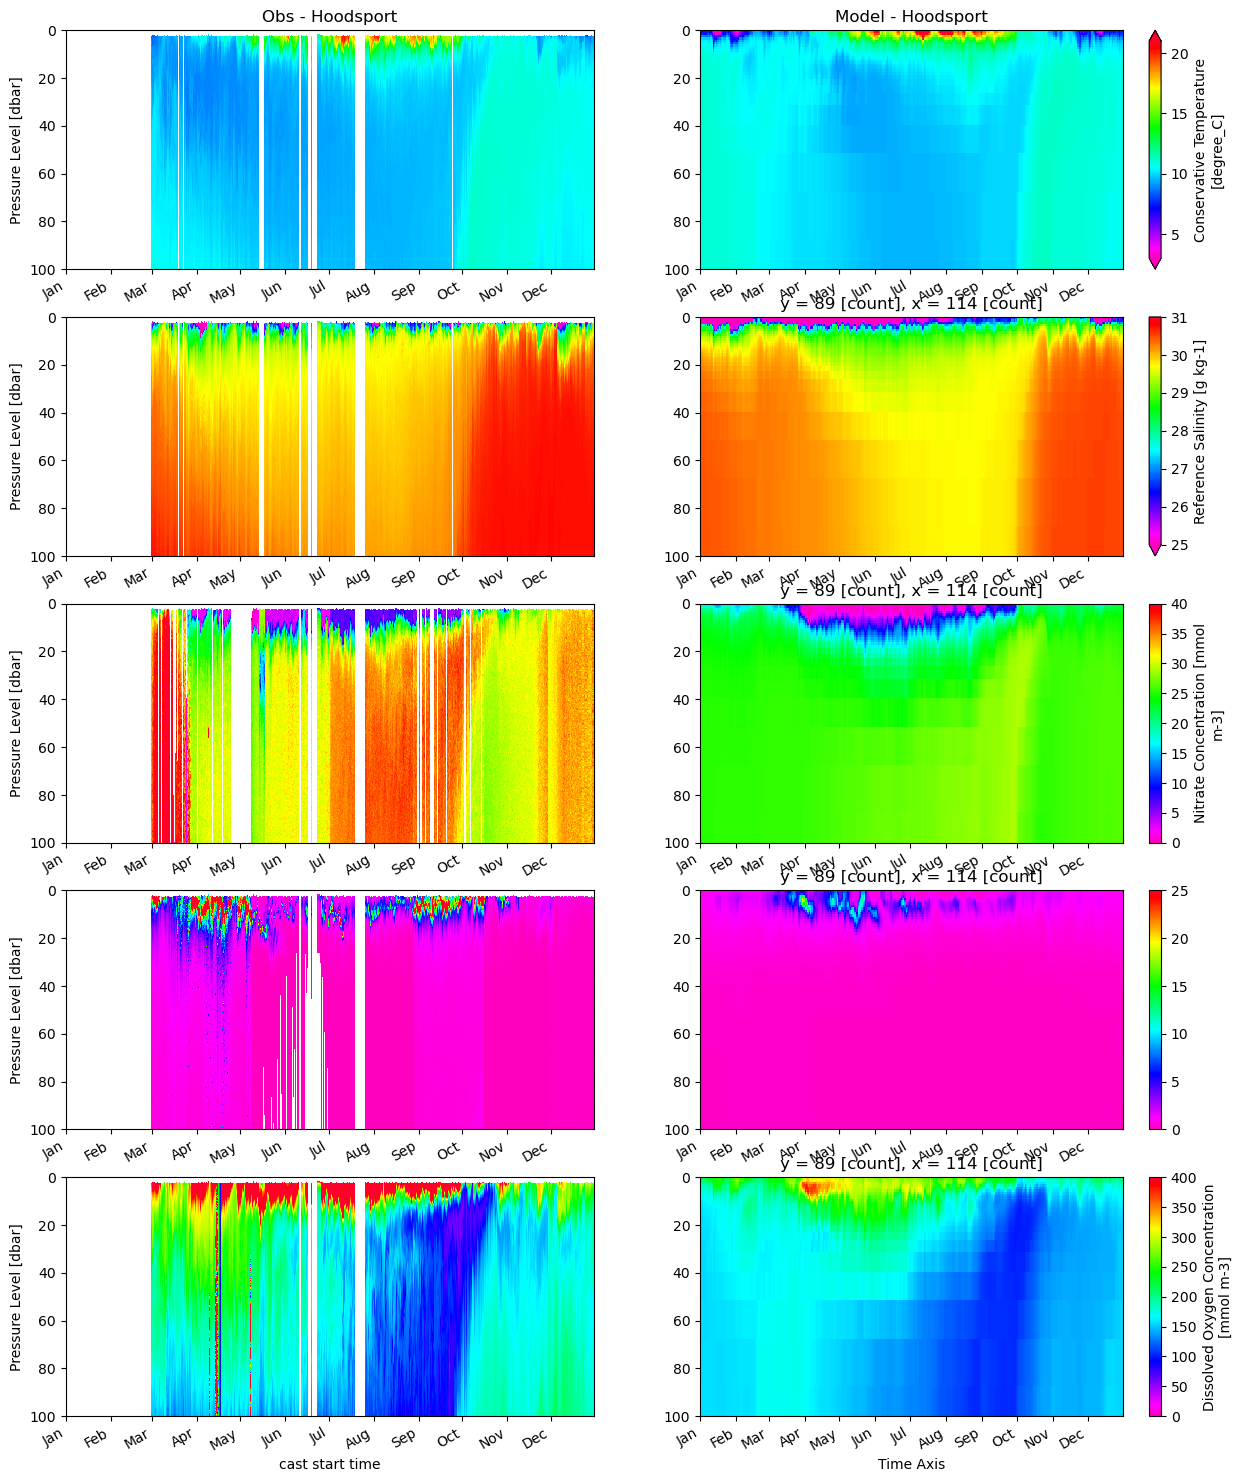

In [249]:
fig, ax = plt.subplots(5, 2, figsize=(15, 18))
temp_obs_HS.plot(ax=ax[0, 0], y="sea_water_pressure", yincrease=False, cmap='gist_rainbow_r', add_colorbar=False, vmin=3, vmax=21, ylim=(100, 0), xlim=(startdate, enddate));
salt_obs_HS.plot(ax=ax[1, 0], y="sea_water_pressure", yincrease=False, cmap= 'gist_rainbow_r', add_colorbar=False, vmin=25, vmax=31, ylim=(100, 0), xlim=(startdate, enddate));
no3_obs_HS.plot(ax=ax[2, 0], y="sea_water_pressure", yincrease=False, cmap='gist_rainbow_r', add_colorbar=False, vmin=0, vmax=40, ylim=(100, 0), xlim=(startdate, enddate));
chl_obs_HS.plot(ax=ax[3, 0], y="sea_water_pressure", yincrease=False, cmap='gist_rainbow_r', add_colorbar=False, vmin=0, vmax=25, ylim=(100, 0), xlim=(startdate, enddate));
oxy_obs_HS.plot(ax=ax[4, 0], y="sea_water_pressure", yincrease=False, cmap='gist_rainbow_r', add_colorbar=False, vmin=0, vmax=400, ylim=(100, 0), xlim=(startdate, enddate));

temphs_ts.plot(ax=ax[0, 1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=3, vmax=21, ylim=(100, 0), xlim=(startdate, enddate));
salths_ts.plot(ax=ax[1, 1], y="deptht", yincrease=False, cmap= 'gist_rainbow_r', vmin=25, vmax=31, ylim=(100, 0), xlim=(startdate, enddate));
no3hs_ts.plot(ax=ax[2, 1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=40, ylim=(100, 0), xlim=(startdate, enddate));
chlhs_ts.plot(ax=ax[3, 1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=25, ylim=(100, 0), xlim=(startdate, enddate));
oxyhs_ts.plot(ax=ax[4, 1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=400, ylim=(100, 0), xlim=(startdate, enddate));

ax[0, 1].set_ylabel('')
ax[1, 1].set_ylabel('')
ax[2, 1].set_ylabel('')
ax[3, 1].set_ylabel('')
ax[4, 1].set_ylabel('')
ax[0, 0].set_xlabel('')
ax[1, 0].set_xlabel('')
ax[2, 0].set_xlabel('')
ax[3, 0].set_xlabel('')
ax[0, 1].set_xlabel('')
ax[1, 1].set_xlabel('')
ax[2, 1].set_xlabel('')
ax[3, 1].set_xlabel('')

ax[0, 0].set_title('Obs - Hoodsport')
ax[0, 1].set_title('Model - Hoodsport')

# Make ticks on occurrences of each month:
ax[0, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[1, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[2, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[3, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[4, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0, 1].xaxis.set_major_locator(mdates.MonthLocator())
ax[1, 1].xaxis.set_major_locator(mdates.MonthLocator())
ax[2, 1].xaxis.set_major_locator(mdates.MonthLocator())
ax[3, 1].xaxis.set_major_locator(mdates.MonthLocator())
ax[4, 1].xaxis.set_major_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
ax[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[2, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[3, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[4, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[1, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[2, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[3, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[4, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

print('Hoodsport in central Hood Canal', startdate, enddate)

North buoy (Hansville) - Hood Canal

North buoy - Hood Canal 2007-01-01T00:00:00+00:00 2007-12-31T00:00:00+00:00


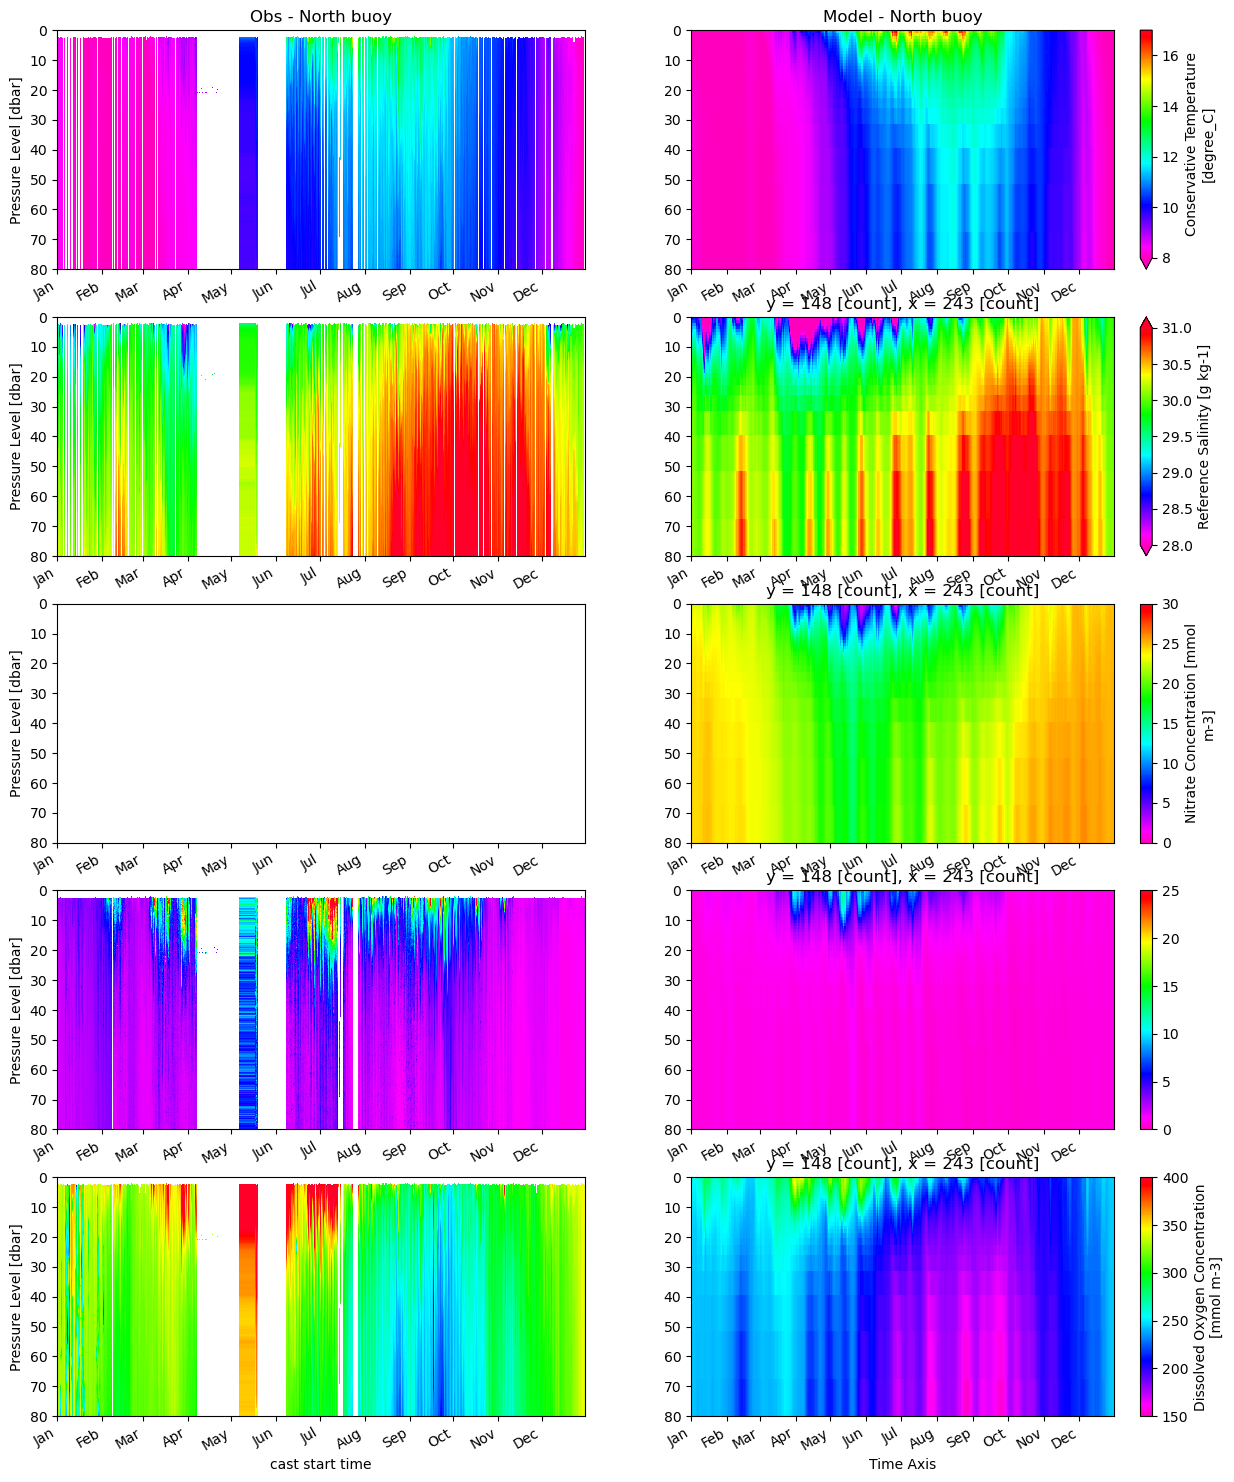

In [236]:
fig, ax = plt.subplots(5, 2, figsize=(15, 18))
temp_obs_NB.plot(ax=ax[0, 0], y="sea_water_pressure", yincrease=False, cmap='gist_rainbow_r', add_colorbar=False, vmin=8, vmax=17, ylim=(80, 0), xlim=(startdate, enddate));
salt_obs_NB.plot(ax=ax[1, 0], y="sea_water_pressure", yincrease=False, cmap= 'gist_rainbow_r', add_colorbar=False, vmin=28, vmax=31, ylim=(80, 0), xlim=(startdate, enddate));
no3_obs_NB.plot(ax=ax[2, 0], y="sea_water_pressure", yincrease=False, cmap='gist_rainbow_r', add_colorbar=False, vmin=0, vmax=30, ylim=(80, 0), xlim=(startdate, enddate));
chl_obs_NB.plot(ax=ax[3, 0], y="sea_water_pressure", yincrease=False, cmap='gist_rainbow_r', add_colorbar=False, vmin=0, vmax=25, ylim=(80, 0), xlim=(startdate, enddate));
oxy_obs_NB.plot(ax=ax[4, 0], y="sea_water_pressure", yincrease=False, cmap='gist_rainbow_r', add_colorbar=False, vmin=150, vmax=400, ylim=(80, 0), xlim=(startdate, enddate));

tempnb_ts.plot(ax=ax[0, 1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=8, vmax=17, ylim=(80, 0), xlim=(startdate, enddate));
saltnb_ts.plot(ax=ax[1, 1], y="deptht", yincrease=False, cmap= 'gist_rainbow_r', vmin=28, vmax=31, ylim=(80, 0), xlim=(startdate, enddate));
no3nb_ts.plot(ax=ax[2, 1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=30, ylim=(80, 0), xlim=(startdate, enddate));
chlnb_ts.plot(ax=ax[3, 1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=25, ylim=(80, 0), xlim=(startdate, enddate));
oxynb_ts.plot(ax=ax[4, 1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=150, vmax=400, ylim=(80, 0), xlim=(startdate, enddate));

ax[0, 1].set_ylabel('')
ax[1, 1].set_ylabel('')
ax[2, 1].set_ylabel('')
ax[3, 1].set_ylabel('')
ax[4, 1].set_ylabel('')
ax[0, 0].set_xlabel('')
ax[1, 0].set_xlabel('')
ax[2, 0].set_xlabel('')
ax[3, 0].set_xlabel('')
ax[0, 1].set_xlabel('')
ax[1, 1].set_xlabel('')
ax[2, 1].set_xlabel('')
ax[3, 1].set_xlabel('')

ax[0, 0].set_title('Obs - North buoy')
ax[0, 1].set_title('Model - North buoy')

# Make ticks on occurrences of each month:
ax[0, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[1, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[2, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[3, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[4, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0, 1].xaxis.set_major_locator(mdates.MonthLocator())
ax[1, 1].xaxis.set_major_locator(mdates.MonthLocator())
ax[2, 1].xaxis.set_major_locator(mdates.MonthLocator())
ax[3, 1].xaxis.set_major_locator(mdates.MonthLocator())
ax[4, 1].xaxis.set_major_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
ax[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[2, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[3, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[4, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[1, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[2, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[3, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[4, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

print('North buoy - Hood Canal', startdate, enddate)

Stat (by hand) --- used stat tools from SalishSeaTools (next)

In [239]:
print(oxy.deptht)
print(max(ds_obs_TW.sea_water_pressure), max(ds_obs_HS.sea_water_pressure), max(ds_obs_NB.sea_water_pressure))

<xarray.DataArray 'deptht' (deptht: 40)>
array([  0.5     ,   1.500003,   2.500011,   3.500031,   4.500071,   5.500151,
         6.50031 ,   7.500623,   8.501236,   9.502433,  10.504766,  11.509312,
        12.518167,  13.535412,  14.568982,  15.634288,  16.761173,  18.007135,
        19.481785,  21.389978,  24.100256,  28.229916,  34.685757,  44.517723,
        58.484333,  76.58559 ,  98.06296 , 121.866516, 147.08946 , 173.11449 ,
       199.57304 , 226.2603  , 253.06664 , 279.93454 , 306.8342  , 333.75018 ,
       360.67453 , 387.6032  , 414.5341  , 441.4661  ], dtype=float32)
Coordinates:
  * deptht   (deptht) float32 0.5 1.5 2.5 3.5 4.5 ... 360.7 387.6 414.5 441.5
Attributes:
    standard_name:  sea_floor_depth
    long_name:      Sea Floor Depth
    units:          metres
    positive:       down


<xarray.DataArray 'sea_water_pressure' ()>
array(35.)
Coordinates:
    sea_water_pressure  float64 35.0
Attributes:
    actual_range:   [ 0. 35.]
    description:    Pressure exerted by overlying water, excluding air pressure.
    ioos_category:  Pressure
    long_name:      Pressure Level
    units:          dbar <xarray.DataArray 'sea_water_pressure' ()>
array(120.)
Coordinates:
    sea_water_pressure  float64 120.0
Attributes:
    actual_range:   [  0. 120.]
    description:    Pressure exerted by overlying water, excluding air pressure.
    ioos_category:  Pressure
    long_name:      Pressure Level
    units:          dbar <xarray.DataArray 'sea_water_pressure' ()>
array(100.)
Coordinates:
    sea_water_pressure  float64 100.0
Attributes:
    actual_range:   [  0. 100.]
    description:    Pressure exerted by overlying water, excluding air pressure.
    ioos_category:  Pressure
    long_name:      Pressure Level
    units:          dbar


In [240]:
dep_mod = oxy.deptht

temp2_obs_TW = temp_obs_TW.sel(sea_water_pressure=np.array(dep_mod[:23]), method="nearest", tolerance=0.5)
temp2_obs_TW = temp2_obs_TW.sel(cast_start_time=oxytw_ts.time_counter, method="nearest")
temp2_obs_HS = temp_obs_HS.sel(sea_water_pressure=np.array(dep_mod[:27]), method="nearest", tolerance=0.5)
temp2_obs_HS = temp2_obs_HS.sel(cast_start_time=oxytw_ts.time_counter, method="nearest")
temp2_obs_NB = temp_obs_NB.sel(sea_water_pressure=np.array(dep_mod[:27]), method="nearest", tolerance=0.5)
temp2_obs_NB = temp2_obs_NB.sel(cast_start_time=oxytw_ts.time_counter, method="nearest")

salt2_obs_TW = salt_obs_TW.sel(sea_water_pressure=np.array(dep_mod[:23]), method="nearest", tolerance=0.5)
salt2_obs_TW = salt2_obs_TW.sel(cast_start_time=oxytw_ts.time_counter, method="nearest")
salt2_obs_HS = salt_obs_HS.sel(sea_water_pressure=np.array(dep_mod[:27]), method="nearest", tolerance=0.5)
salt2_obs_HS = salt2_obs_HS.sel(cast_start_time=oxytw_ts.time_counter, method="nearest")
salt2_obs_NB = salt_obs_NB.sel(sea_water_pressure=np.array(dep_mod[:27]), method="nearest", tolerance=0.5)
salt2_obs_NB = salt2_obs_NB.sel(cast_start_time=oxytw_ts.time_counter, method="nearest")

no32_obs_TW = no3_obs_TW.sel(sea_water_pressure=np.array(dep_mod[:23]), method="nearest", tolerance=0.5)
no32_obs_TW = no32_obs_TW.sel(cast_start_time=oxytw_ts.time_counter, method="nearest")
no32_obs_HS = no3_obs_HS.sel(sea_water_pressure=np.array(dep_mod[:27]), method="nearest", tolerance=0.5)
no32_obs_HS = no32_obs_HS.sel(cast_start_time=oxytw_ts.time_counter, method="nearest")
no32_obs_NB = no3_obs_NB.sel(sea_water_pressure=np.array(dep_mod[:27]), method="nearest", tolerance=0.5)
no32_obs_NB = no32_obs_NB.sel(cast_start_time=oxytw_ts.time_counter, method="nearest")

chl2_obs_TW = chl_obs_TW.sel(sea_water_pressure=np.array(dep_mod[:23]), method="nearest", tolerance=0.5)
chl2_obs_TW = chl2_obs_TW.sel(cast_start_time=oxytw_ts.time_counter, method="nearest")
chl2_obs_HS = chl_obs_HS.sel(sea_water_pressure=np.array(dep_mod[:27]), method="nearest", tolerance=0.5)
chl2_obs_HS = chl2_obs_HS.sel(cast_start_time=oxytw_ts.time_counter, method="nearest")
chl2_obs_NB = chl_obs_NB.sel(sea_water_pressure=np.array(dep_mod[:27]), method="nearest", tolerance=0.5)
chl2_obs_NB = chl2_obs_NB.sel(cast_start_time=oxytw_ts.time_counter, method="nearest")

oxy2_obs_TW = oxy_obs_TW.sel(sea_water_pressure=np.array(dep_mod[:23]), method="nearest", tolerance=0.5)
oxy2_obs_TW = oxy2_obs_TW.sel(cast_start_time=oxytw_ts.time_counter, method="nearest")
oxy2_obs_HS = oxy_obs_HS.sel(sea_water_pressure=np.array(dep_mod[:27]), method="nearest", tolerance=0.5)
oxy2_obs_HS = oxy2_obs_HS.sel(cast_start_time=oxytw_ts.time_counter, method="nearest")
oxy2_obs_NB = oxy_obs_NB.sel(sea_water_pressure=np.array(dep_mod[:27]), method="nearest", tolerance=0.5)
oxy2_obs_NB = oxy2_obs_NB.sel(cast_start_time=oxytw_ts.time_counter, method="nearest")


oxy2_obs_TW.shape

(365, 23)

In [241]:
# Bias and Swillmott 
# Twanoh
bias_temp_tw = temptw_ts[:, :23].mean() - temp2_obs_TW.mean()
bias_salt_tw = salttw_ts[:, :23].mean() - salt2_obs_TW.mean()
bias_no3_tw = no3tw_ts[:, :23].mean() - no32_obs_TW.mean()
bias_chl_tw = chltw_ts[:, :23].mean() - chl2_obs_TW.mean()
bias_oxy_tw = oxytw_ts[:, :23].mean() - oxy2_obs_TW.mean()

swmt_temp_tw = 1 - (((temptw_ts[:, :23] - temp2_obs_TW)**2).sum() / (( (temptw_ts[:, :23] - temp2_obs_TW.mean()).__abs__() + (temp2_obs_TW - temp2_obs_TW.mean()).__abs__() )**2).sum())
swmt_salt_tw = 1 - (((salttw_ts[:, :23] - salt2_obs_TW)**2).sum() / (( (salttw_ts[:, :23] - salt2_obs_TW.mean()).__abs__() + (salt2_obs_TW - salt2_obs_TW.mean()).__abs__() )**2).sum())
swmt_no3_tw = 1 - (((no3tw_ts[:, :23] - no32_obs_TW)**2).sum() / (( (no3tw_ts[:, :23] - no32_obs_TW.mean()).__abs__() + (no32_obs_TW - no32_obs_TW.mean()).__abs__() )**2).sum())
swmt_chl_tw = 1 - (((chltw_ts[:, :23] - chl2_obs_TW)**2).sum() / (( (chltw_ts[:, :23] - chl2_obs_TW.mean()).__abs__() + (chl2_obs_TW - chl2_obs_TW.mean()).__abs__() )**2).sum())
swmt_oxy_tw = 1 - (((oxytw_ts[:, :23] - oxy2_obs_TW)**2).sum() / (( (oxytw_ts[:, :23] - oxy2_obs_TW.mean()).__abs__() + (oxy2_obs_TW - oxy2_obs_TW.mean()).__abs__() )**2).sum())

# Hoodsport
bias_temp_hs = temphs_ts[:, :27].mean() - temp2_obs_HS.mean()
bias_salt_hs = salths_ts[:, :27].mean() - salt2_obs_HS.mean()
bias_no3_hs = no3hs_ts[:, :27].mean() - no32_obs_HS.mean()
bias_chl_hs = chlhs_ts[:, :27].mean() - chl2_obs_HS.mean()
bias_oxy_hs = oxyhs_ts[:, :27].mean() - oxy2_obs_HS.mean()

swmt_temp_hs = 1 - (((temphs_ts[:, :27] - temp2_obs_HS)**2).sum() / (( (temphs_ts[:, :27] - temp2_obs_HS.mean()).__abs__() + (temp2_obs_HS - temp2_obs_HS.mean()).__abs__() )**2).sum())
swmt_salt_hs = 1 - (((salths_ts[:, :27] - salt2_obs_HS)**2).sum() / (( (salths_ts[:, :27] - salt2_obs_HS.mean()).__abs__() + (salt2_obs_HS - salt2_obs_HS.mean()).__abs__() )**2).sum())
swmt_no3_hs = 1 - (((no3hs_ts[:, :27] - no32_obs_HS)**2).sum() / (( (no3hs_ts[:, :27] - no32_obs_HS.mean()).__abs__() + (no32_obs_HS - no32_obs_HS.mean()).__abs__() )**2).sum())
#swmt_chl_hs = 1 - (((chlhs_ts[:, :27] - chl2_obs_HS)**2).sum() / (( (chlhs_ts[:, :27] - chl2_obs_HS.mean()).__abs__() + (chl2_obs_HS - chl2_obs_HS.mean()).__abs__() )**2).sum())
swmt_oxy_hs = 1 - (((oxyhs_ts[:, :27] - oxy2_obs_HS)**2).sum() / (( (oxyhs_ts[:, :27] - oxy2_obs_HS.mean()).__abs__() + (oxy2_obs_HS - oxy2_obs_HS.mean()).__abs__() )**2).sum())

# Hansville (North buoy)
bias_temp_nb = tempnb_ts[:, :27].mean() - temp2_obs_NB.mean()
bias_salt_nb = saltnb_ts[:, :27].mean() - salt2_obs_NB.mean()
bias_no3_nb = no3nb_ts[:, :27].mean() - no32_obs_NB.mean()
bias_chl_nb = chlnb_ts[:, :27].mean() - chl2_obs_NB.mean()
bias_oxy_nb = oxynb_ts[:, :27].mean() - oxy2_obs_NB.mean()

swmt_temp_nb = 1 - (((tempnb_ts[:, :27] - temp2_obs_NB)**2).sum() / (( (tempnb_ts[:, :27] - temp2_obs_NB.mean()).__abs__() + (temp2_obs_NB - temp2_obs_NB.mean()).__abs__() )**2).sum())
swmt_salt_nb = 1 - (((saltnb_ts[:, :27] - salt2_obs_NB)**2).sum() / (( (saltnb_ts[:, :27] - salt2_obs_NB.mean()).__abs__() + (salt2_obs_NB - salt2_obs_NB.mean()).__abs__() )**2).sum())
swmt_no3_nb = 1 - (((no3nb_ts[:, :27] - no32_obs_NB)**2).sum() / (( (no3nb_ts[:, :27] - no32_obs_NB.mean()).__abs__() + (no32_obs_NB - no32_obs_NB.mean()).__abs__() )**2).sum())
swmt_chl_nb = 1 - (((chlnb_ts[:, :27] - chl2_obs_NB)**2).sum() / (( (chlnb_ts[:, :27] - chl2_obs_NB.mean()).__abs__() + (chl2_obs_NB - chl2_obs_NB.mean()).__abs__() )**2).sum())
swmt_oxy_nb = 1 - (((oxynb_ts[:, :27] - oxy2_obs_NB)**2).sum() / (( (oxynb_ts[:, :27] - oxy2_obs_NB.mean()).__abs__() + (oxy2_obs_NB - oxy2_obs_NB.mean()).__abs__() )**2).sum())


<xarray.DataArray ()>
array(0.35910483)
Coordinates:
    y        int64 72
    x        int64 123 <xarray.DataArray ()>
array(-0.92873719)
Coordinates:
    y        int64 72
    x        int64 123 <xarray.DataArray ()>
array(-5.15679104)
Coordinates:
    y        int64 72
    x        int64 123 <xarray.DataArray ()>
array(-1.32748423)
Coordinates:
    y        int64 72
    x        int64 123 <xarray.DataArray ()>
array(-55.87855041)
Coordinates:
    y        int64 72
    x        int64 123
<xarray.DataArray ()>
array(0.47323846)
Coordinates:
    y        int64 72
    x        int64 123 <xarray.DataArray ()>
array(0.264039)
Coordinates:
    y        int64 72
    x        int64 123 <xarray.DataArray ()>
array(0.48605728)
Coordinates:
    y        int64 72
    x        int64 123 <xarray.DataArray ()>
array(0.26591138)
Coordinates:
    y        int64 72
    x        int64 123 <xarray.DataArray ()>
array(0.44311092)
Coordinates:
    y        int64 72
    x        int64 123


Text(0.5, 1.0, 'Oxygen (µmol/L)')

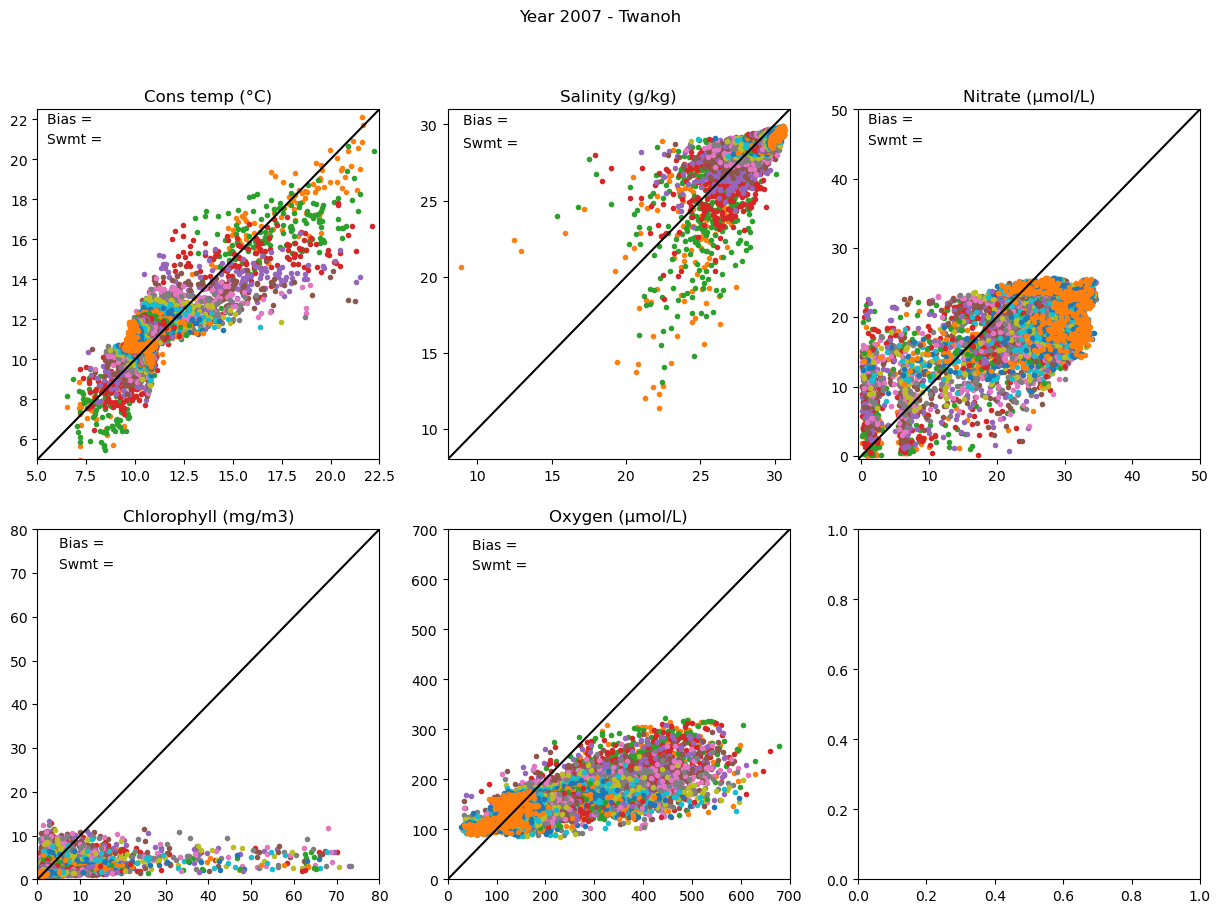

In [242]:
print(bias_temp_tw, bias_salt_tw, bias_no3_tw, bias_chl_tw, bias_oxy_tw)
print(swmt_temp_tw, swmt_salt_tw, swmt_no3_tw, swmt_chl_tw, swmt_oxy_tw)

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle(f'Year {syear} - Twanoh')

ax[0, 0].plot(temp2_obs_TW, temptw_ts[:,:23],'.')
ax[0, 0].set_xlim(5, 22.5)
ax[0, 0].set_ylim(5, 22.5)
ax[0, 0].plot([5, 22.5], [5, 22.5], 'k-');
ax[0, 0].text(5.5, 21.8, 'Bias = ')
ax[0, 0].text(5.5, 20.8, 'Swmt = ')
ax[0, 0].set_title('Cons temp (°C)')
ax[0, 1].plot(salt2_obs_TW, salttw_ts[:,:23],'.')
ax[0, 1].set_xlim(8, 31)
ax[0, 1].set_ylim(8, 31)
ax[0, 1].plot([8, 31], [8, 31], 'k-');
ax[0, 1].text(9, 30, 'Bias = ')
ax[0, 1].text(9, 28.5, 'Swmt = ')
ax[0, 1].set_title('Salinity (g/kg)')
ax[0, 2].plot(no32_obs_TW, no3tw_ts[:,:23],'.')
ax[0, 2].set_xlim(-0.5, 50)
ax[0, 2].set_ylim(-0.5, 50)
ax[0, 2].plot([-0.5, 50], [-0.5, 50], 'k-');
ax[0, 2].text(1, 48, 'Bias = ')
ax[0, 2].text(1, 45, 'Swmt = ')
ax[0, 2].set_title('Nitrate (µmol/L)')
ax[1, 0].plot(chl2_obs_TW, chltw_ts[:,:23],'.')
ax[1, 0].set_xlim(0, 80)
ax[1, 0].set_ylim(0, 80)
ax[1, 0].plot([0, 80], [0, 80], 'k-');
ax[1, 0].text(5, 76, 'Bias = ')
ax[1, 0].text(5, 71, 'Swmt = ')
ax[1, 0].set_title('Chlorophyll (mg/m3)')
ax[1, 1].plot(oxy2_obs_TW, oxytw_ts[:,:23],'.')
ax[1, 1].set_xlim(0, 700)
ax[1, 1].set_ylim(0, 700)
ax[1, 1].plot([0, 700], [0, 700], 'k-');
ax[1, 1].text(50, 660, 'Bias = ')
ax[1, 1].text(50, 620, 'Swmt = ')
ax[1, 1].set_title('Oxygen (µmol/L)')

Text(0.5, 1.0, 'Obs')

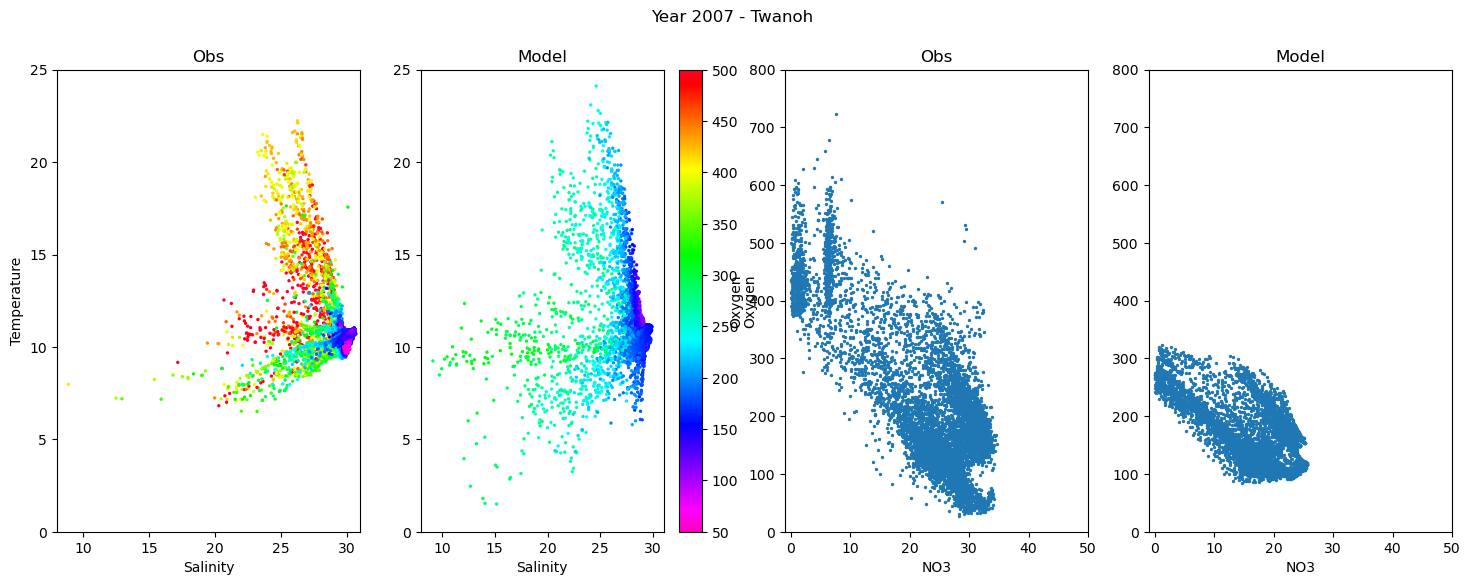

In [243]:
fig, ax = plt.subplots(1, 4, figsize=(18, 6))
fig.suptitle(f'Year {syear} - Twanoh')
obs1 = ax[0].scatter(salt2_obs_TW, temp2_obs_TW, 2, oxy2_obs_TW, cmap='gist_rainbow_r', vmin=50, vmax=500);
mdl1 = ax[1].scatter(salttw_ts, temphs_ts, 2, oxytw_ts, cmap='gist_rainbow_r', vmin=50, vmax=500);
obs2 = ax[2].scatter(no32_obs_TW, oxy2_obs_TW, s=2);
mdl2 = ax[3].scatter(no3tw_ts, oxytw_ts, s=2);
plt.colorbar(mdl1, ax=ax[1])
mdl1.colorbar.set_label('Oxygen')
ax[0].set_xlim(8, 31)
ax[1].set_xlim(8, 31)
ax[0].set_ylim(0, 25)
ax[1].set_ylim(0, 25)
ax[2].set_xlim(-1, 50)
ax[3].set_xlim(-1, 50)
ax[2].set_ylim(0, 800)
ax[3].set_ylim(0, 800)
ax[0].set_ylabel('Temperature')
ax[0].set_xlabel('Salinity')
ax[1].set_xlabel('Salinity')
ax[2].set_ylabel('Oxygen')
ax[2].set_xlabel('NO3')
ax[3].set_xlabel('NO3')
ax[1].set_title('Model')
ax[3].set_title('Model')
ax[0].set_title('Obs')
ax[2].set_title('Obs')

<xarray.DataArray ()>
array(0.43414287) <xarray.DataArray ()>
array(-0.62647198) <xarray.DataArray ()>
array(-6.66188105) <xarray.DataArray ()>
array(-2.71378891) <xarray.DataArray ()>
array(-60.2060063)
<xarray.DataArray ()>
array(0.41170819)
Coordinates:
    y        int64 72
    x        int64 123 <xarray.DataArray ()>
array(0.26475858)
Coordinates:
    y        int64 72
    x        int64 123 <xarray.DataArray ()>
array(0.50359082)
Coordinates:
    y        int64 72
    x        int64 123 <xarray.DataArray ()>
array(0.53201254)
Coordinates:
    y        int64 72
    x        int64 123


Text(0.5, 1.0, 'Oxygen (µmol/L)')

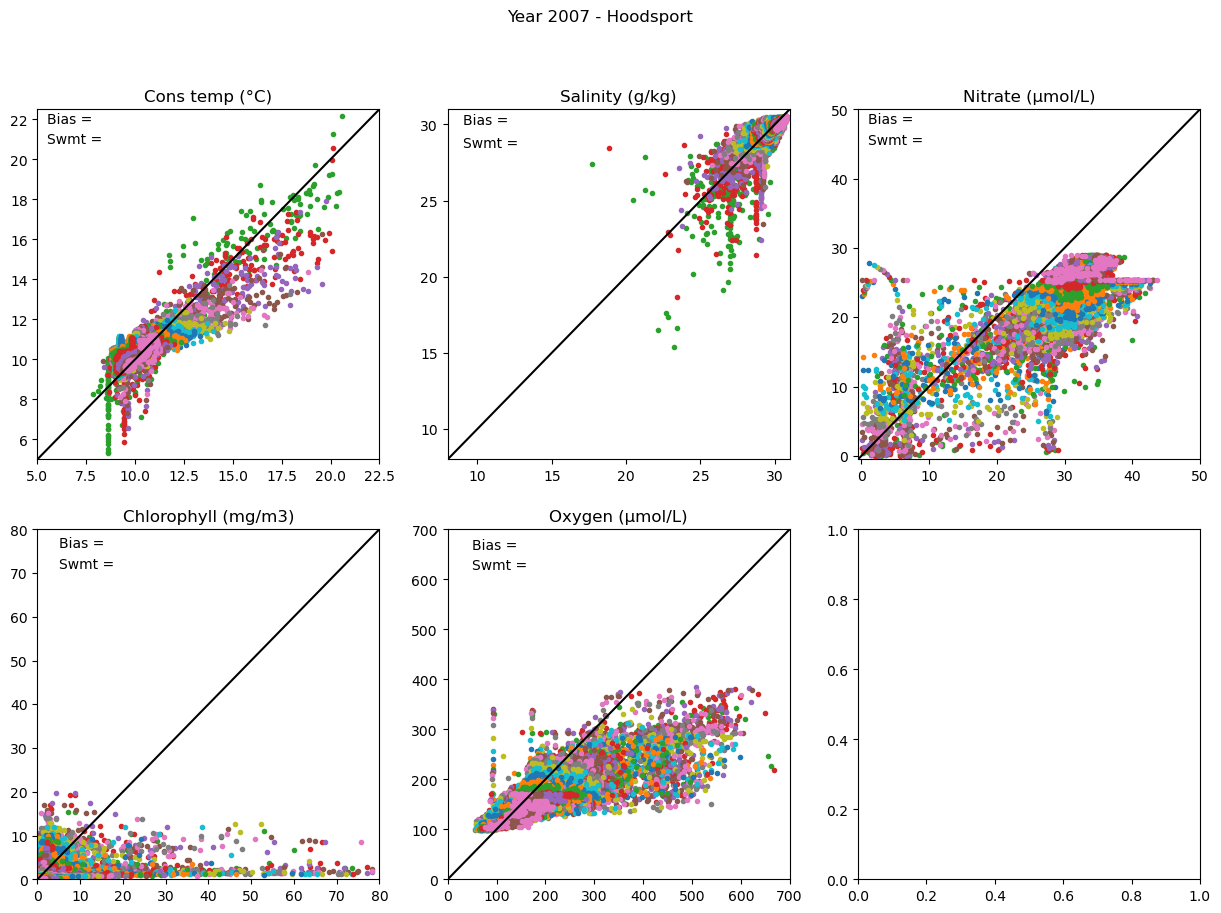

In [244]:
print(bias_temp_hs, bias_salt_hs, bias_no3_hs, bias_chl_hs, bias_oxy_hs)
print(swmt_temp_hs, swmt_salt_hs, swmt_no3_hs, swmt_oxy_hs)

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle(f'Year {syear} - Hoodsport')

ax[0, 0].plot(temp2_obs_HS, temphs_ts[:,:27],'.')
ax[0, 0].set_xlim(5, 22.5)
ax[0, 0].set_ylim(5, 22.5)
ax[0, 0].plot([5, 22.5], [5, 22.5], 'k-');
ax[0, 0].text(5.5, 21.8, 'Bias = ')
ax[0, 0].text(5.5, 20.8, 'Swmt = ')
ax[0, 0].set_title('Cons temp (°C)')
ax[0, 1].plot(salt2_obs_HS, salths_ts[:,:27],'.')
ax[0, 1].set_xlim(8, 31)
ax[0, 1].set_ylim(8, 31)
ax[0, 1].plot([8, 31], [8, 31], 'k-');
ax[0, 1].text(9, 30, 'Bias = ')
ax[0, 1].text(9, 28.5, 'Swmt = ')
ax[0, 1].set_title('Salinity (g/kg)')
ax[0, 2].plot(no32_obs_HS, no3hs_ts[:,:27],'.')
ax[0, 2].set_xlim(-0.5, 50)
ax[0, 2].set_ylim(-0.5, 50)
ax[0, 2].plot([-0.5, 50], [-0.5, 50], 'k-');
ax[0, 2].text(1, 48, 'Bias = ')
ax[0, 2].text(1, 45, 'Swmt = ')
ax[0, 2].set_title('Nitrate (µmol/L)')
ax[1, 0].plot(chl2_obs_HS, chlhs_ts[:,:27],'.')
ax[1, 0].set_xlim(0, 80)
ax[1, 0].set_ylim(0, 80)
ax[1, 0].plot([0, 80], [0, 80], 'k-');
ax[1, 0].text(5, 76, 'Bias = ')
ax[1, 0].text(5, 71, 'Swmt = ')
ax[1, 0].set_title('Chlorophyll (mg/m3)')
ax[1, 1].plot(oxy2_obs_HS, oxyhs_ts[:,:27],'.')
ax[1, 1].set_xlim(0, 700)
ax[1, 1].set_ylim(0, 700)
ax[1, 1].plot([0, 700], [0, 700], 'k-');
ax[1, 1].text(50, 660, 'Bias = ')
ax[1, 1].text(50, 620, 'Swmt = ')
ax[1, 1].set_title('Oxygen (µmol/L)')

Text(0.5, 1.0, 'Obs')

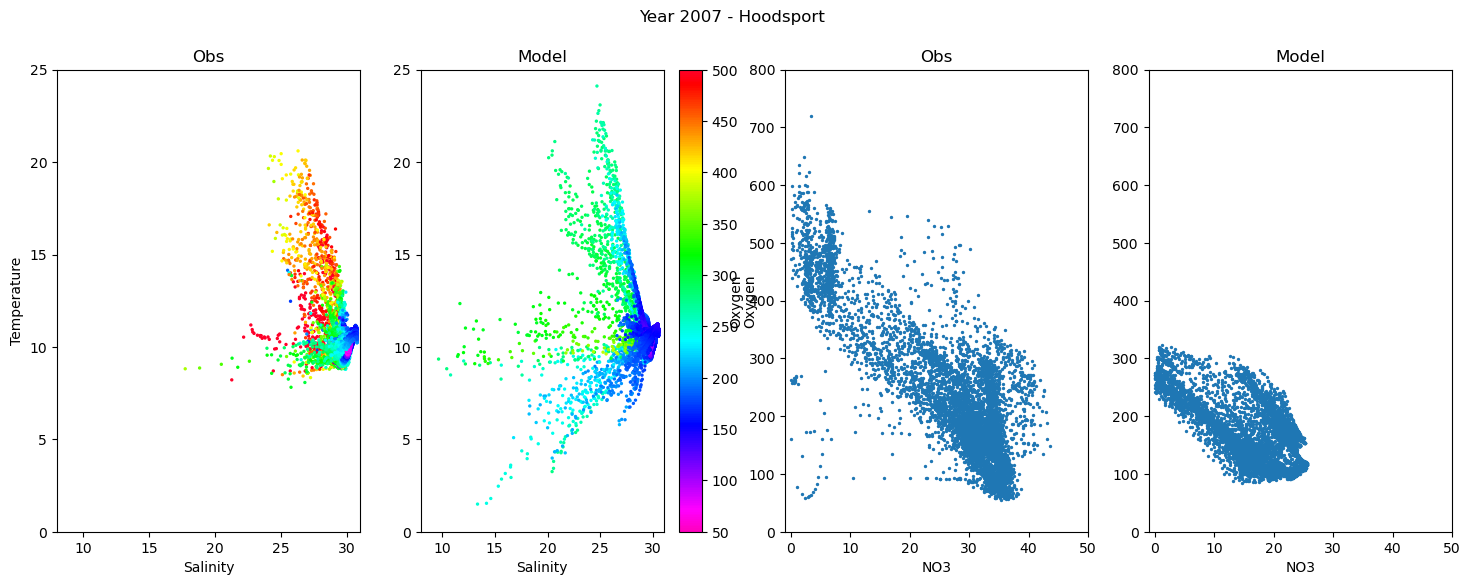

In [245]:
fig, ax = plt.subplots(1, 4, figsize=(18, 6))
fig.suptitle(f'Year {syear} - Hoodsport')
obs1 = ax[0].scatter(salt2_obs_HS, temp2_obs_HS, 2, oxy2_obs_HS, cmap='gist_rainbow_r', vmin=50, vmax=500);
mdl1 = ax[1].scatter(salths_ts, temphs_ts, 2, oxyhs_ts, cmap='gist_rainbow_r', vmin=50, vmax=500);
obs2 = ax[2].scatter(no32_obs_HS, oxy2_obs_HS, s=2);
mdl2 = ax[3].scatter(no3tw_ts, oxytw_ts, s=2);
plt.colorbar(mdl1, ax=ax[1])
mdl1.colorbar.set_label('Oxygen')
ax[0].set_xlim(8, 31)
ax[1].set_xlim(8, 31)
ax[0].set_ylim(0, 25)
ax[1].set_ylim(0, 25)
ax[2].set_xlim(-1, 50)
ax[3].set_xlim(-1, 50)
ax[2].set_ylim(0, 800)
ax[3].set_ylim(0, 800)
ax[0].set_ylabel('Temperature')
ax[0].set_xlabel('Salinity')
ax[1].set_xlabel('Salinity')
ax[2].set_ylabel('Oxygen')
ax[2].set_xlabel('NO3')
ax[3].set_xlabel('NO3')
ax[1].set_title('Model')
ax[3].set_title('Model')
ax[0].set_title('Obs')
ax[2].set_title('Obs')

<xarray.DataArray ()>
array(0.07081056) <xarray.DataArray ()>
array(-0.32956856) <xarray.DataArray ()>
array(nan) <xarray.DataArray ()>
array(-4.14109853) <xarray.DataArray ()>
array(-88.91172058)
<xarray.DataArray ()>
array(0.9410068)
Coordinates:
    y        int64 72
    x        int64 123 <xarray.DataArray ()>
array(0.73913377)
Coordinates:
    y        int64 72
    x        int64 123 <xarray.DataArray ()>
array(nan)
Coordinates:
    y        int64 72
    x        int64 123 <xarray.DataArray ()>
array(0.47323033)
Coordinates:
    y        int64 72
    x        int64 123 <xarray.DataArray ()>
array(0.43507687)
Coordinates:
    y        int64 72
    x        int64 123


Text(0.5, 1.0, 'Oxygen (µmol/L)')

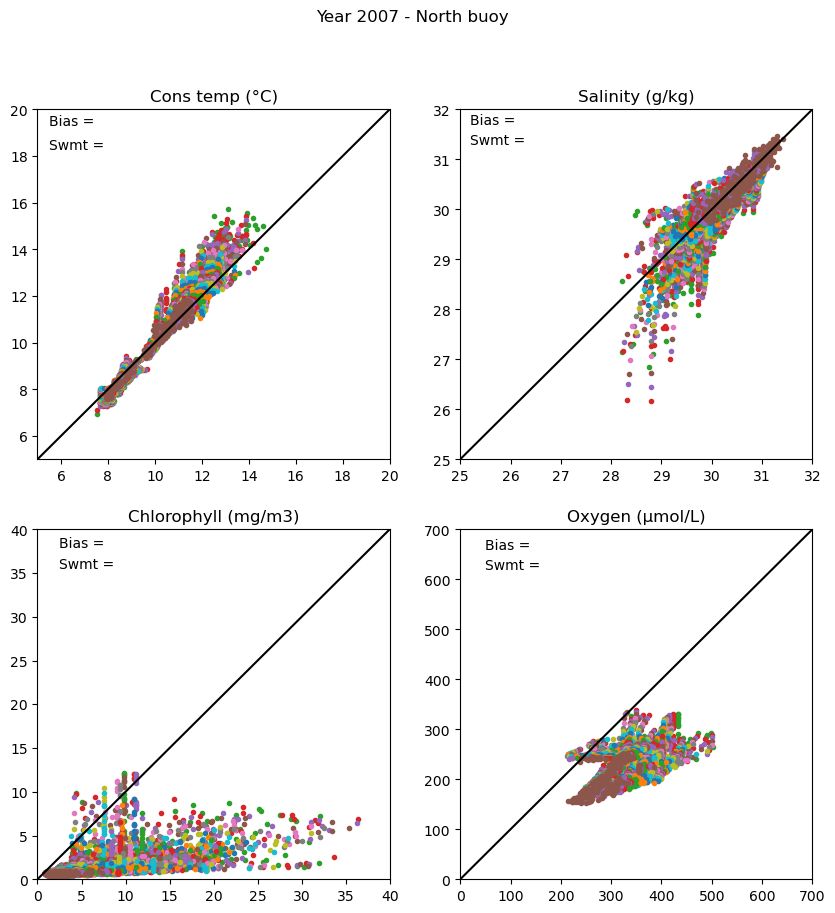

In [246]:
print(bias_temp_nb, bias_salt_nb, bias_no3_nb, bias_chl_nb, bias_oxy_nb)
print(swmt_temp_nb, swmt_salt_nb, swmt_no3_nb, swmt_chl_nb, swmt_oxy_nb)
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f'Year {syear} - North buoy')

ax[0, 0].plot(temp2_obs_NB, tempnb_ts[:,:27],'.')
ax[0, 0].set_xlim(5, 20)
ax[0, 0].set_ylim(5, 20)
ax[0, 0].plot([5, 22.5], [5, 22.5], 'k-');
ax[0, 0].text(5.5, 19.3, 'Bias = ')
ax[0, 0].text(5.5, 18.3, 'Swmt = ')
ax[0, 0].set_title('Cons temp (°C)')
ax[0, 1].plot(salt2_obs_NB, saltnb_ts[:,:27],'.')
ax[0, 1].set_xlim(25, 32)
ax[0, 1].set_ylim(25, 32)
ax[0, 1].plot([25, 32], [25, 32], 'k-');
ax[0, 1].text(25.2, 31.7, 'Bias = ')
ax[0, 1].text(25.2, 31.3, 'Swmt = ')
ax[0, 1].set_title('Salinity (g/kg)')
ax[1, 0].plot(chl2_obs_NB, chlnb_ts[:,:27],'.')
ax[1, 0].set_xlim(0, 40)
ax[1, 0].set_ylim(0, 40)
ax[1, 0].plot([0, 40], [0, 40], 'k-');
ax[1, 0].text(2.5, 38, 'Bias = ')
ax[1, 0].text(2.5, 35.5, 'Swmt = ')
ax[1, 0].set_title('Chlorophyll (mg/m3)')
ax[1, 1].plot(oxy2_obs_NB, oxynb_ts[:,:27],'.')
ax[1, 1].set_xlim(0, 700)
ax[1, 1].set_ylim(0, 700)
ax[1, 1].plot([0, 700], [0, 700], 'k-');
ax[1, 1].text(50, 660, 'Bias = ')
ax[1, 1].text(50, 620, 'Swmt = ')
ax[1, 1].set_title('Oxygen (µmol/L)')

Text(0.5, 1.0, 'Obs')

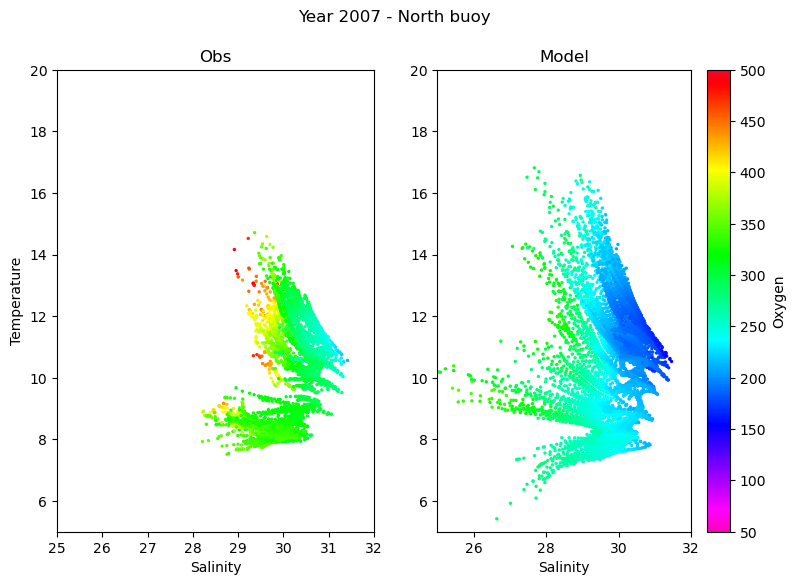

In [247]:
fig, ax = plt.subplots(1, 2, figsize=(9, 6))
fig.suptitle(f'Year {syear} - North buoy')
obs1 = ax[0].scatter(salt2_obs_NB, temp2_obs_NB, 2, oxy2_obs_NB, cmap='gist_rainbow_r', vmin=50, vmax=500);
mdl1 = ax[1].scatter(saltnb_ts, tempnb_ts, 2, oxynb_ts, cmap='gist_rainbow_r', vmin=50, vmax=500);
plt.colorbar(mdl1, ax=ax[1])
mdl1.colorbar.set_label('Oxygen')
ax[0].set_xlim(25, 32)
ax[1].set_xlim(25, 32)
ax[0].set_ylim(5, 20)
ax[1].set_ylim(5, 20)
ax[0].set_ylabel('Temperature')
ax[0].set_xlabel('Salinity')
ax[1].set_xlabel('Salinity')
ax[1].set_title('Model')
ax[0].set_title('Obs')